# STOIIP & Recoverable Resources Calculations - Part 1

MONTE CARLO SIMULATION FOR STOCK-TANK-OIL-INITIALLY-IN-PLACE (STOOIP) & RECOVERABLE RESOURCES

In [1]:
# Load libraries
import statistics
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1.  Geometric Correction Factor (g)

### THIS SECTION IS BASED ON WORK DONE BY AGILE SCIENTIFIC WHICH IS HEREBY ACKNOWLEDGED

In [3]:
# Geometric_Correction_Factor calculation based on reservoir thickness and closure height of prospect
thick = 80                    # reservoir thickness in m
height = 100                  # closure height in m
ratio = thick / height        # ranges from 0.4 to 1.0

# Define shape of prospect feature; 'flat', 'round' otherwise it's a slab of 1
top = 'flat'

if top == 'round':
    g = -0.6 * ratio + 1
elif top == 'flat':
    g = -0.3 * ratio + 1
else:
    g = 1

print("The ratio =", ratio)
print("The Geometric Correction_Factor =", g)

The ratio = 0.8
The Geometric Correction_Factor = 0.76


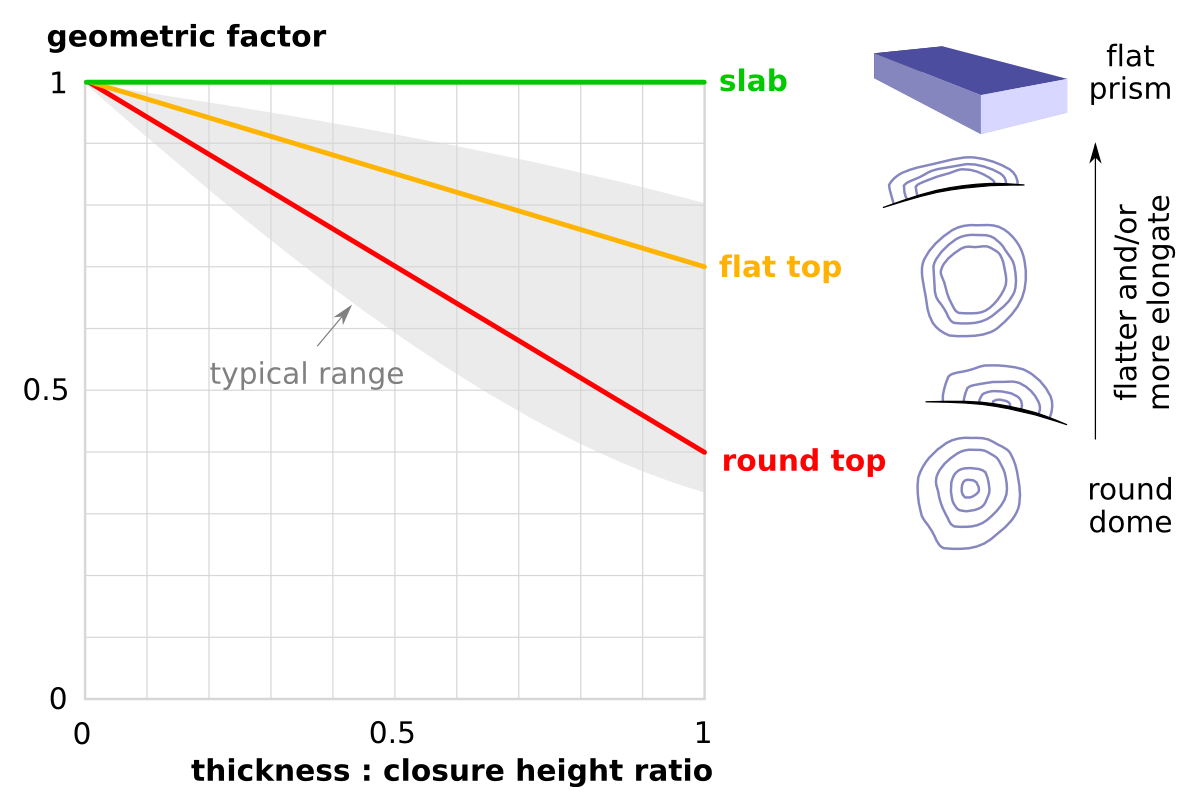

In [4]:
# Display an image file illustrating the Geometric Correction Factor
from IPython import display
display.Image("http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600)

## 2. Key Inputs (Only alter the values in this section!)

In [5]:
# GENERAL INPUT VARIABLES

n = 100000                   # number of samples or runs
seed = 121                   # fix the seed point - use RANDOM_STATE
bins = 500                   # number of bins
m3_to_bbl_conversion = 6.28981

# SPECIFIC INPUT VARIABLES

#1. AREA (meters^2)          TRIANGULAR DISTRIBUTION
a_min = 4100000              # scalar - Lower bound of the distribution support
a_max = 4250000              # scalar - Upper bound of the distribution support
c1 = 0.5                     # scalar - The location of the triangle's peak 

#2. THICKNESS (meters)      TRIANGULAR DISTRIBUTION
t_min = 70                   # scalar - Lower bound of the distribution support
t_max = 110                  # scalar - Upper bound of the distribution support 
c2 = 0.5                     # scalar - The location of the triangle's peak 

#3. NET-TO-GROSS (NTG)      TRIANGULAR DISTRIBUTION
ntg_min = 0.50               # scalar - Lower bound of the distribution support
ntg_max = 0.70               # scalar - Upper bound of the distribution support 
c3 = 0.5                     # scalar - The location of the triangle's peak

#4. POROSITY                 TRUNCATED NORMAL DISTRIBUTION
por_mean = 0.14              # Mean
por_std = 0.042              # Standard Deviation
por_lower = 0.00             # lower limit
por_upper = 1.00             # Upper limit

#5. WATER SATURATION         TRUNCATED NORMAL DISTRIBUTION
sw_mean = 0.25               # Mean
sw_std = 0.103               # Standard Deviation
sw_lower = 0.00              # lower limit
sw_upper = 1.00              # Upper limit

#6. OIL FORMATION VOLUME FACTOR (Bo)   UNIFORM DISTRIBUTION
bo_min = 1.03                # scalar - Lower bound of the distribution support
bo_max = bo_min+0.01         # scalar - Upper bound of the distribution support

#7. RECOVERY FACTOR (RF)     TRIANGULAR DISTRIBUTION
rf_min = 0.15                # scalar - Lower bound of the distribution support
rf_max = 0.35                # scalar - Upper bound of the distribution support 
c7 = 0.5                     # scalar - The location of the triangle's peak)

#8. GEOMETRIC CORRECTION FACTOR (g)   UNIFORM DISTRIBUTION
g_min = 0.76                 # scalar - Lower bound of the distribution support
g_max = g_min+0.04           # scalar - Upper bound of the distribution support 

## 3.  Probability Distributions for Inputs - Random Number Generators

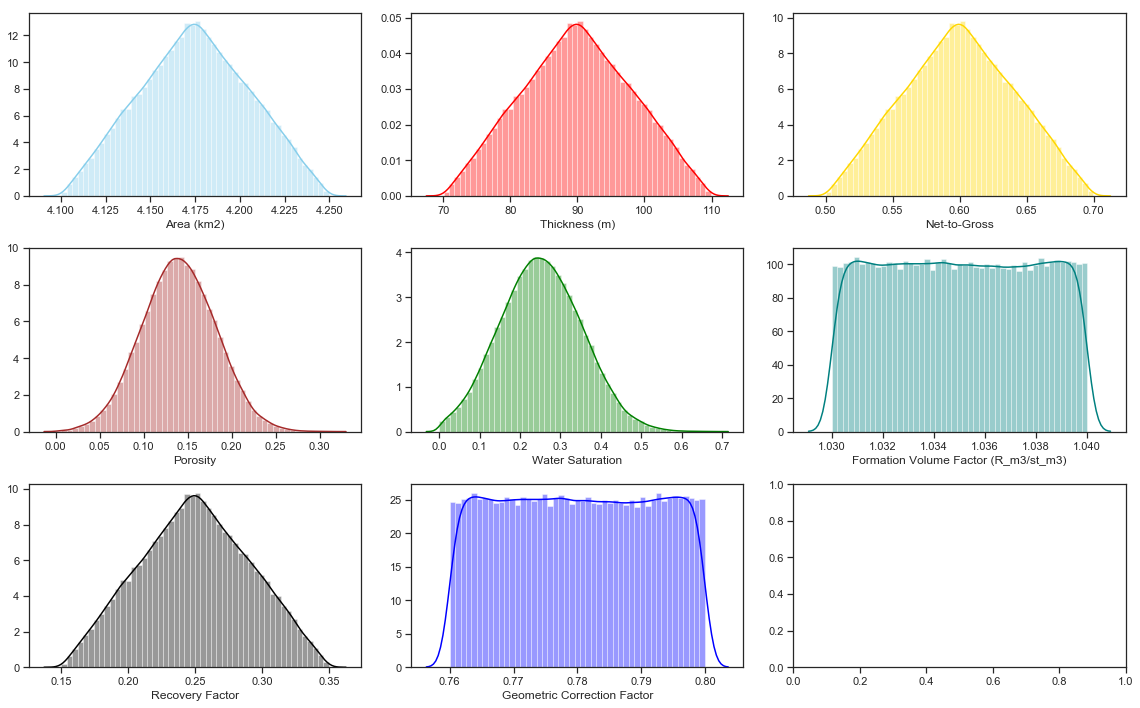

In [35]:
# Calculate Individual Probabilty Distributions using SciPy algorithms 
Area = stats.triang.rvs(c1, loc=a_min, scale=a_max-a_min, size=n, random_state = seed)
Thickness = stats.triang.rvs(c2, loc=t_min, scale=t_max-t_min, size=n, random_state = seed)
NTG = stats.triang.rvs(c3, loc=ntg_min, scale=ntg_max-ntg_min, size=n, random_state=seed)
# POR = stats.norm(por_mean, por_std).rvs(size = n, random_state=seed) 
POR = stats.truncnorm((por_lower - por_mean) / por_std, (por_upper - por_mean) / por_std, loc=por_mean, scale=por_std).rvs(size = n, random_state=seed) 
Sw = stats.truncnorm((sw_lower - sw_mean) / sw_std, (sw_upper - sw_mean) / sw_std, loc=sw_mean, scale=sw_std).rvs(size = n, random_state=seed) 
# Sw = stats.norm(sw_mean, sw_std).rvs(size = n, random_state=seed) 
Bo = stats.uniform.rvs(loc = bo_min, scale=bo_max-bo_min, size=n, random_state = seed)
RF = stats.triang.rvs(c7, loc=rf_min, scale=rf_max-rf_min, size=n, random_state=seed)
g = stats.uniform.rvs(loc = g_min, scale=g_max-g_min, size=n, random_state = seed)

# Plot Individual Probability Distributions to visualise inputs
# Set the figures
sns.set(color_codes=True)
sns.set_style("dark")
sns.set_style("ticks")
f, axes = plt.subplots(3, 3, figsize=(16, 10), )
f.subplots_adjust(hspace=0.25, wspace=0.15)
# Seaborn distribution plots
sns.distplot( Area/1e6, color="skyblue", ax=axes[0, 0], axlabel='Area (km2)')
sns.distplot( Thickness , color="red", ax=axes[0, 1], axlabel='Thickness (m)')
sns.distplot( NTG , color="gold", ax=axes[0, 2], axlabel='Net-to-Gross')
sns.distplot( POR , color="brown", ax=axes[1, 0], axlabel='Porosity')
sns.distplot( Sw , color="green", ax=axes[1, 1], axlabel='Water Saturation')
sns.distplot( Bo , color="teal", ax=axes[1, 2], axlabel='Formation Volume Factor (R_m3/st_m3)')
sns.distplot( RF , color="black", ax=axes[2, 0], axlabel='Recovery Factor')
sns.distplot( g , color="blue", ax=axes[2, 1], axlabel='Geometric Correction Factor')
plt.tight_layout()
plt.show()
# plt.savefig('Property_Distribution.png')   # to save the figure as a .PNG file in the working directory

## 4. STOIIP & Recoverable Resources Calculations 

In [12]:
# Calculations
GRV = g * Area * Thickness                                            # GRV in cubic meters
NRV = GRV * NTG                                                       # NRV in cubic meters
HCPV = NRV * POR * (1-Sw)                                             # HCPV in cubic meters
OIIP_m3 = HCPV / Bo                                                   # OIIP in cubic meters
OIIP = (HCPV * m3_to_bbl_conversion / 1E6) / Bo                       # OIIP in mmbbls
Resources_m3 = OIIP_m3 * RF                                           # Recoverable Resources in cubic meters
Resources = OIIP * RF                                                 # Recoverable Resources in mmbbls

# Statistics
print("The minimum OIIP = %.1f mmbbls" % (min(OIIP)))
print("The maximum OIIP = %.1f mmbbls" % (max(OIIP)))
print("The mean OIIP = %.1f mmbbls" % (statistics.mean(OIIP)))                     # Arithmetic mean (“average”) of data
print("The OIIP std dev = %.1f mmbbls" % (statistics.stdev(OIIP)))                 # Sample standard deviation of data
print("The median OIIP = %.1f mmbbls" % (statistics.median(OIIP)))                 # Median (middle value) of data
print("The median_grouped OIIP = %.1f mmbbls" % (statistics.median_grouped(OIIP))) # Median or 50th percentile of grouped data
print("P99 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 1))) 
print("P90 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 10))) 
print("P50 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 50))) 
print("P10 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 90))) 
print("P01 OIIP = %.1f mmbbls" % (np.percentile(OIIP, 99)))

The minimum OIIP = 0.1 mmbbls
The maximum OIIP = 183.9 mmbbls
The mean OIIP = 111.6 mmbbls
The OIIP std dev = 36.6 mmbbls
The median OIIP = 112.0 mmbbls
The median_grouped OIIP = 111.5 mmbbls
P99 OIIP = 29.9 mmbbls
P90 OIIP = 62.7 mmbbls
P50 OIIP = 112.0 mmbbls
P10 OIIP = 161.2 mmbbls
P01 OIIP = 182.4 mmbbls


In [19]:
# Display descriptive statistics of the numpy OIIP array. Compare the SciPy stats to Pandas stats - should be identical
print(stats.describe(OIIP))

DescribeResult(nobs=100000, minmax=(0.10689553933454224, 183.90893073727773), mean=111.63992170916158, variance=1337.4425765470469, skewness=-0.1125543799935826, kurtosis=-0.601615429153306)


In [21]:
# Create and Display Pandas DataFrame Statistics
headers = ('Area (m2)','Thickness (m)','NTG','Porosity','Sw','Bo (m3/m3)','GRV (m3)','NRV (m3)','HCPV (m3)','OIIP (m3)',
               'OIIP (mmbo)')
data = [Area, Thickness, NTG, POR, Sw, Bo, GRV, NRV, HCPV, OIIP_m3, OIIP]
data_dict = dict(zip(headers, data))
df = pd.DataFrame(data_dict)
df.describe()

,Area (m2),Thickness (m),NTG,Porosity,Sw,Bo (m3/m3),GRV (m3),NRV (m3),HCPV (m3),OIIP (m3),OIIP (mmbo)
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,4.175015e+06,90.004095,0.600020,0.140102,0.252256,1.034999,2.937171e+08,1.775909e+08,1.838720e+07,1.774933e+07,111.639922
std,3.068177e+04,8.181806,0.040909,0.041978,0.100545,0.002893,3.312438e+07,3.198588e+07,6.067782e+06,5.814335e+06,36.571062
min,4.100258e+06,70.068842,0.500344,0.000160,0.000029,1.030000,2.183483e+08,1.092493e+08,1.750489e+04,1.699503e+04,0.106896
25%,4.152981e+06,84.128238,0.570641,0.111649,0.182210,1.032495,2.690180e+08,1.535128e+08,1.401656e+07,1.357543e+07,85.386854
50%,4.174918e+06,89.978030,0.599890,0.139907,0.250701,1.034989,2.929912e+08,1.757625e+08,1.842558e+07,1.780268e+07,111.975467
75%,4.197195e+06,95.918797,0.629594,0.168627,0.320786,1.037521,3.180807e+08,2.002617e+08,2.293679e+07,2.210730e+07,139.050689
max,4.249617e+06,109.897827,0.699489,0.316618,0.683302,1.040000,3.736187e+08,2.613422e+08,3.040752e+07,2.923919e+07,183.908931


In [23]:
# Export Volumetrics Data to a CSV file
pd.DataFrame(df).to_csv("D:/Oil and Gas/OIIP.csv")

## 5. Cumulative Distribution Function (CDF)

### Using histograms to plot a cumulative distribution

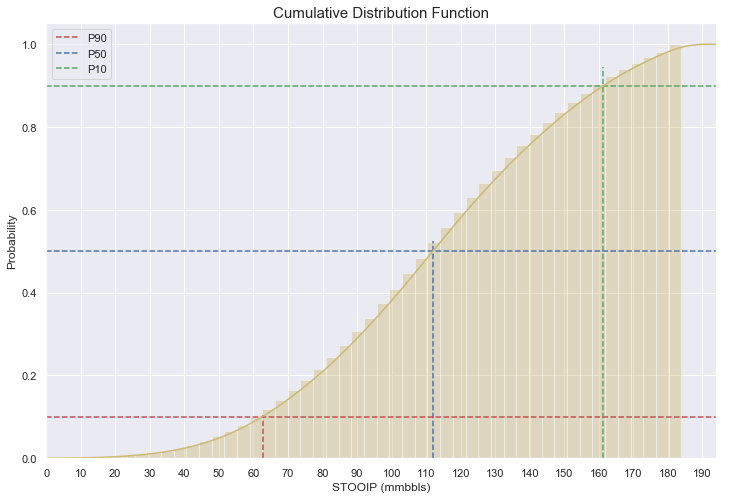

In [37]:
# PLot Cumulative Distribution Function using Seaborn
sns.set_style("ticks")
sns.set(color_codes=True)
fig = plt.figure(figsize=(12,8))
plt.tight_layout()
plt.ylabel('Probability')
plt.xlabel('STOOIP (mmbbls)')
plt.title('Cumulative Distribution Function', fontsize = 15)
plt.xlim(0, max(OIIP)+10)
plt.xticks(rotation=0)
plt.locator_params(axis='x', nbins=20)
plt.locator_params(axis='y', nbins=10)
plt.grid(True)
# Add vertical and horizontal lines
plt.axvline(x=np.percentile(OIIP, 10), ymax=0.1, color='r', linestyle='--', label='P90')
plt.axvline(x=np.percentile(OIIP, 50), ymax=0.5, color='b', linestyle='--', label='P50')
plt.axvline(x=np.percentile(OIIP, 90), ymax=0.9, color='g', linestyle='--', label='P10')
plt.axhline(y=0.1, xmax=np.percentile(OIIP, 10), color='r', linestyle='--')
plt.axhline(y=0.5, xmax=np.percentile(OIIP, 50), color='b', linestyle='--')
plt.axhline(y=0.9, xmax=np.percentile(OIIP, 90), color='g', linestyle='--')
sns.distplot(OIIP, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True), color='y')
plt.legend(loc=2); plt.show()

## 6. Probability Distribution Function (PDF)

### Using Gaussian KDE

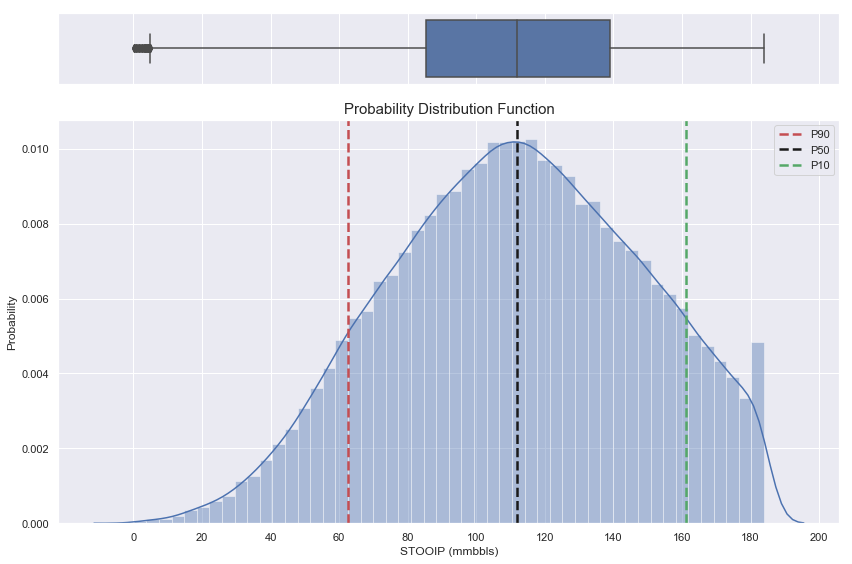

In [24]:
sns.set_style("ticks")
sns.set(color_codes=True)

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(12,8), gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(OIIP, ax=ax_box)
sns.distplot(OIIP, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Add vertical and horizontal lines
plt.axvline(x=np.percentile(OIIP, 10), color='r', linestyle='--', label='P90', linewidth = 2.5)
plt.axvline(x=np.percentile(OIIP, 50), color='k', linestyle='--', label='P50', linewidth = 2.5)
plt.axvline(x=np.percentile(OIIP, 90), color='g', linestyle='--', label='P10', linewidth = 2.5)

plt.ylabel('Probability')
plt.xlabel('STOOIP (mmbbls)')
plt.xticks(np.arange(0, df['OIIP (mmbo)'].max()+20, step=20))
plt.title('Probability Distribution Function', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.show()

## 7. QA/QC 

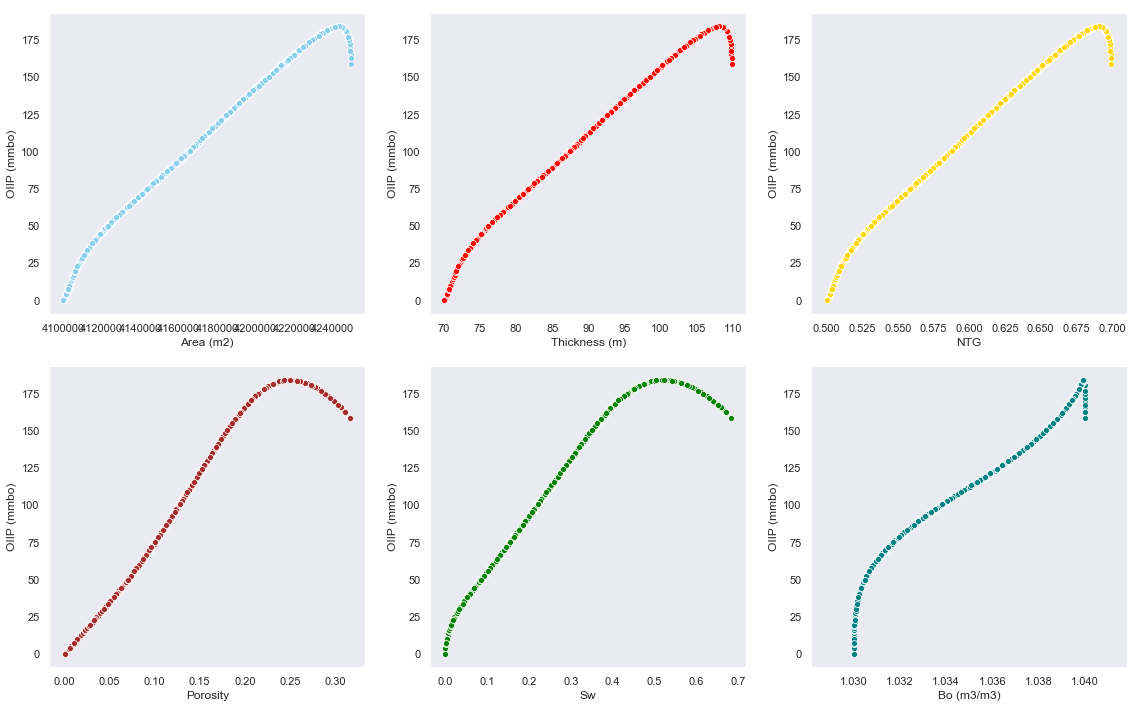

In [37]:
# Plot Input Probability Distributions vs STOIIP
sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_style("dark")
f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.subplots_adjust(hspace=0.25, wspace=0.15)
sns.scatterplot(x='Area (m2)', y='OIIP (mmbo)', data=df, color="skyblue", ax=axes[0, 0])                
sns.scatterplot(x='Thickness (m)', y='OIIP (mmbo)', data=df, color="red", ax=axes[0, 1])
sns.scatterplot(x='NTG', y='OIIP (mmbo)', data=df, color="gold", ax=axes[0, 2])
sns.scatterplot(x='Porosity', y='OIIP (mmbo)', data=df, color="brown", ax=axes[1, 0])
sns.scatterplot(x='Sw', y='OIIP (mmbo)', data=df, color="green", ax=axes[1, 1])
sns.scatterplot(x='Bo (m3/m3)', y='OIIP (mmbo)', data=df, color="teal", ax=axes[1, 2])
plt.tight_layout()
plt.show()

To figure out which other SciPy probability distributions can be used, below is a useful link.

In [5]:
from IPython.core.display import HTML
HTML('http://cmdlinetips.com/2018/03/probability-distributions-in-python/')